In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import os
import io
import time

In [4]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True

)

path_to_file = os.path.dirname(path_to_zip)+'./spa-eng/spa.txt'

In [7]:
pd.read_table('./spa-eng/spa-eng/spa.txt')

,Go.,Ve.
0,Go.,Vete.
1,Go.,Vaya.
2,Go.,Váyase.
3,Hi.,Hola.
4,Run!,¡Corre!
...,...,...
118958,There are four main causes of alcohol-related ...,Hay cuatro causas principales de muertes relac...
118959,There are mothers and fathers who will lie awa...,Hay madres y padres que se quedan despiertos d...
118960,A carbon footprint is the amount of carbon dio...,Una huella de carbono es la cantidad de contam...
118961,Since there are usually multiple websites on a...,Como suele haber varias páginas web sobre cual...


In [ ]:
# mec = Mecab(dicpath='C:/mecab/mecab-ko-dic/')

In [8]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())    # 아스키 바꾸는

  # 단어와 특수 문자 사이에 공백 넣기
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)  # 대괄호 삭제

  # 영어와 일부 특수문자(a-z, A-Z, ".", "?", "!", ",")를 제외하고는 전부 공백으로 변환
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()   # 공백 없애기

  # 문장의 시작과 끝에 <start> 토큰화 <end> 토큰 추가
  w = '<start> ' + w + ' <end>'
  return w

In [9]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [10]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')  # 읽고, 공백없애고, 줄바꿈으로 쪼개기
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]   # n개의 샘플을 뽑아서 탭으로 쪼개서 토큰을 리스에 담음
  return zip(*word_pairs)  # zip으로 묶어줌 => 영어와 스페인어가 매칭되서 묶여짐

In [11]:
# 지금까지 선언한 전처리 함수들을 실제 데이터셋에 적용한다면?
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [12]:
# 토큰화 / 정수 인코딩 / 패딩을 하는 함수
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)   # 문장 학습

  tensor = lang_tokenizer.texts_to_sequences(lang)   # 토큰의 인덱스를 부여

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')     # 길이 맞춤

  return tensor, lang_tokenizer   # 토큰과 토큰나이저 출력

In [13]:
# 입력된 데이터셋에 대해서 토큰화 / 정수 인코딩 / 패딩을 수행
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)   # 두개 문장 리턴

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)   # 토큰단위로 짜라서 인덱스 값으로 맞추고 패딩이 됨
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [15]:
# 샘플 수는 3만개로 제한하며  => 5000개
# 실제로 토큰화, 정수 인코딩, 패딩을 수행
num_examples = 5000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# 최대 길이 계산
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [16]:
max_length_targ

8

In [17]:
max_length_inp

12

In [18]:
target_tensor.shape

(5000, 8)

In [19]:
input_tensor.shape

(5000, 12)

In [20]:
# 8:2 비율로 분할
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 샘플 개수
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

4000 4000 1000 1000


In [22]:
input_tensor_train[0]

array([   1,   17,   81, 2135,    3,    2,    0,    0,    0,    0,    0,
          0])

In [23]:
target_tensor_train[0]

array([  1,   5,  84, 143,   3,   2,   0,   0])

In [24]:
input_tensor_val[0]

array([  1,  73, 873,   3,   2,   0,   0,   0,   0,   0,   0,   0])

In [25]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [26]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
17 ----> se
81 ----> puede
2135 ----> romper
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> it
84 ----> may
143 ----> break
3 ----> .
2 ----> <end>


In [27]:
# 하이퍼파라미터 정의
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256   # 차원
units = 1024    # 벡터사이즈

# 단어 집합의 크기 정의
vocab_inp_size = len(inp_lang.word_index)+1        
vocab_tar_size = len(targ_lang.word_index)+1

# 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
# .from_tensor_slices : 데이터를 배치단위로 가져올수 있는 클래스
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [28]:
# 첫번째 배치에 대해서 크기 출력
example_input_batch, example_target_batch = next(iter(dataset))   # next : next할때마다 배치단위를 가져와서 인풋이랑 타겟을 각각 가져와서 담음
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 12]), TensorShape([64, 8]))

In [29]:
# 인코더 구현
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    # 선언부
    self.batch_sz = batch_sz
    self.enc_units = enc_units   # lstm 사이즈

    # 임베딩 층
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    # GRU
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True, # 인코더의 모든 히든스테이트를 사용.
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')   # 초기값 설정

  # 함수형 API와 유사하게 실제 동작은 이곳에서 정의
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)   # 아웃풋과 스테이트 값 출력 됨
    return output, state

  # 초기 은닉 상태는 제로 벡터로 사용
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [30]:
# 인코더 구현
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)   # 클래스는 객체를 만들어주어야함

In [31]:
# 제로 벡터 생성
sample_hidden = encoder.initialize_hidden_state()   # 클래스 호출해서 히든스테이트 값 만들고

# 임의의 테스트 입력과 제로 벡터를 입력
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)   # 64샘플데이터, 제로로채워둔 히든값

# (64, 16, 1024)는 각각 (배치 크기, 문장 길이, 은닉 상태의 차원)
# (64, 1024)는 각각 (배치 크기, 은닉 상태의 차원)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 12, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [32]:
# 바다나우 어텐션 구현
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)
    print('query_with_time_axis의 shape', query_with_time_axis.shape)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [33]:
# 바다나우 어텐션 실제 구현 및 리턴한 값 크기 확인
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape)) # 입력문장 수 16

query_with_time_axis의 shape (64, 1, 1024)
Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 12, 1)


In [34]:
# 바다나우 어텐션을 사용한 디코더 구현

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # 어텐션 사용
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output는 인코더의모든 시점의 은닉 상태
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # 임베딩 벡터와 바다나우 어텐션으로 얻은 컨텍스트 벡터를 concat.
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # concat한 결과를 GRU의 입력으로 사용.
    output, state = self.gru(x)

    # 현재 시점의 은닉 상태를 리턴
    output = tf.reshape(output, (-1, output.shape[2]))

    # 이로부터 현재 시점의 단어 예측
    x = self.fc(output)

    return x, state, attention_weights

In [37]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

query_with_time_axis의 shape (64, 1, 1024)
Decoder output shape: (batch_size, vocab size) (64, 1389)


In [36]:
# 옵티마이저와 손실 함수 구현
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))  # logical_not : 트루펄스가 바뀌는?
  loss_ = loss_object(real, pred)
  print(loss_.dtype)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [38]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    # enc_output = 모든 시점의 인코더의 hidden state : h1, h2, h3, h4
    # 어텐션 메커니즘의 values

    # enc_hidden : 마지막 시점의 인코더의 hidden state : h4
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    # 디코더의 첫번째 hidden state로 사용
    dec_hidden = enc_hidden

    # <SOS> 토큰
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # 교사 강요 - 현재 시점의 타겟을 다음 시점의 입력으로 사용한다.
    for t in range(1, targ.shape[1]):
      # enc_output는 인코더의 모든 시점의 은닉 상태
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # 현재 시점의 타겟을 다음 시점의 입력으로 사용
      #tf.print(targ[:, t])
      # print(targ[:, t].shape)
      dec_input = tf.expand_dims(targ[:, t], 1)
      #tf.print(dec_input)
      # print(dec_input.shape)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  # 미분
  gradients = tape.gradient(loss, variables)

  # 파라미터 업데이트
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [39]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):   # take : 한번 실행
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

query_with_time_axis의 shape (64, 1, 1024)
<dtype: 'float32'>
query_with_time_axis의 shape (64, 1, 1024)
<dtype: 'float32'>
query_with_time_axis의 shape (64, 1, 1024)
<dtype: 'float32'>
query_with_time_axis의 shape (64, 1, 1024)
<dtype: 'float32'>
query_with_time_axis의 shape (64, 1, 1024)
<dtype: 'float32'>
query_with_time_axis의 shape (64, 1, 1024)
<dtype: 'float32'>
query_with_time_axis의 shape (64, 1, 1024)
<dtype: 'float32'>
query_with_time_axis의 shape (64, 1, 1024)
<dtype: 'float32'>
query_with_time_axis의 shape (64, 1, 1024)
<dtype: 'float32'>
query_with_time_axis의 shape (64, 1, 1024)
<dtype: 'float32'>
query_with_time_axis의 shape (64, 1, 1024)
<dtype: 'float32'>
query_with_time_axis의 shape (64, 1, 1024)
<dtype: 'float32'>
query_with_time_axis의 shape (64, 1, 1024)
<dtype: 'float32'>
query_with_time_axis의 shape (64, 1, 1024)
<dtype: 'float32'>
Epoch 1 Batch 0 Loss 4.4800
Epoch 1 Loss 2.6407
Time taken for 1 epoch 9.355271339416504 sec

Epoch 2 Batch 0 Loss 2.0988
Epoch 2 Loss 1.9391
Time

In [40]:
# 테스트 단계에서의 동작
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  # 입력된 문장에 대해서 전처리
  sentence = preprocess_sentence(sentence)

  # 토큰화 및 정수 인코딩 및 패딩
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]

  # 인코더 수행
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  # 시작 토큰 정의
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  # 테스트 단계
  for t in range(max_length_targ):
    # 디코더를 동작.
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # 뒤에서 그래프를 그리기 위해서 어텐션 가중치를 저장
    # attention_weights = tf.reshape(attention_weights, (-1, ))
    # attention_plot[t] = attention_weights.numpy()

    # 예측으로부터 얻은 정수
    predicted_id = tf.argmax(predictions[0]).numpy()

    # 현재 시점에 예측한 단어를 최종 결과로 리턴할 문장에 추가
    result += targ_lang.index_word[predicted_id] + ' '

    # eos를 만나면 종료
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # 현재 시점의 예측을 다음 시점의 입력으로 사용
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [41]:
# 어텐션 가중치의 시각화
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [42]:
# 입력된 문장에 대해서 번역 및 시각화
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

query_with_time_axis의 shape (1, 1, 1024)
query_with_time_axis의 shape (1, 1, 1024)
query_with_time_axis의 shape (1, 1, 1024)
query_with_time_axis의 shape (1, 1, 1024)
query_with_time_axis의 shape (1, 1, 1024)
query_with_time_axis의 shape (1, 1, 1024)
Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s a fox . <end> 


C:\Users\bitcamp\Anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == "__main__":
C:\Users\bitcamp\Anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


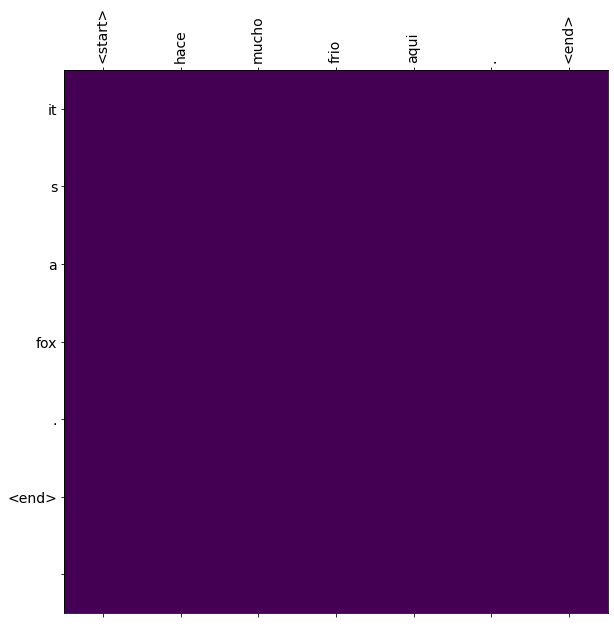

In [43]:
translate(u'hace mucho frio aqui.')